# PwBandsWorkChain

In this notebook we compute the DFT bands on the same k-points used for the Wannier90 interpolated DFT bands of example `1_Band_interpolation_W90_DFT`. 

In [1]:
from aiida import orm, load_profile
load_profile()

Profile<uuid='3745313b017b418697d37cbf16c4e7ef' name='generic'>

In [2]:
from aiida_quantumespresso.workflows.pw.base import PwBaseWorkChain

from aiida_wannier90_workflows.utils.workflows.builder.serializer import print_builder 
from aiida_wannier90_workflows.utils.workflows.builder.setter import set_parallelization, set_num_bands
from aiida_wannier90_workflows.utils.workflows.builder.submit import submit_and_add_group 
from aiida_wannier90_workflows.utils.workflows.builder.generator.post import (
    get_pwbands_builder_from_wannier,
    
)
from aiida_wannier90_workflows.workflows import Wannier90BandsWorkChain

In [3]:
# Loading the wannier90 workchain performed before (notebook 1), to be used here.
w90_wkchain = orm.load_node(1441)

In [4]:
builder = get_pwbands_builder_from_wannier(w90_wkchain)

parallelization = {
    "npool": 1,
}
set_parallelization(builder, parallelization, process_class=PwBaseWorkChain)

builder.pw.metadata = {'options': {'max_wallclock_seconds': 43200,
                                   #'queue_name':'s3par',
                                 'resources': {'num_machines': 1,
                                               'num_mpiprocs_per_machine':1,
                                               },
                                 'withmpi': True}}

print_builder(builder)


{'kpoints': 'GAMMA-X-U-K-GAMMA-L-W-X<None>',
 'kpoints_distance': 0.2,
 'kpoints_force_parity': False,
 'max_iterations': 5,
 'pw': {'code': 'pw_develop@local_slurm<365>',
        'metadata': {'options': {'max_wallclock_seconds': 43200,
                                 'resources': {'num_machines': 1,
                                               'num_mpiprocs_per_machine': 1},
                                 'withmpi': True}},
        'parallelization': {'npool': 1},
        'parameters': {'CONTROL': {'calculation': 'bands',
                                   'etot_conv_thr': 0.0002,
                                   'forc_conv_thr': 0.001,
                                   'tprnfor': True,
                                   'tstress': True},
                       'ELECTRONS': {'conv_thr': 8e-10,
                                     'diago_full_acc': True,
                                     'electron_maxstep': 80,
                                     'mixing_beta': 0.4},
      

In [5]:
from aiida.engine import submit

In [6]:
run = None

In [7]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 67dcfe27-f03f-40fd-83e0-e466c5134458 (pk: 1500) (aiida.workflows:quantumespresso.pw.base)


In [10]:
!verdi process report {run.pk}

2024-02-19 17:09:53 [726 | REPORT]: [1500|PwBaseWorkChain|run_process]: launching PwCalculation<1503> iteration #1
2024-02-19 17:10:59 [727 | REPORT]: [1500|PwBaseWorkChain|results]: work chain completed after 1 iterations
2024-02-19 17:10:59 [728 | REPORT]: [1500|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned


## Comparison with W90@QE

In case you want to plot the bands via command line:

```bash
aiida-wannier90-workflows plot bands 1500 1441
```

In [12]:
import matplotlib.pyplot as plt

# DFT bands and last occupied band index.
dft, b = orm.load_node(1500),4 


bands_qe = dft.outputs.output_band

In [16]:
# Just a way to have nice plotting.

l_x = []
l_names = []
l_remove = []

for i in bands_qe.labels:
    if len(l_x)>0:
        if i[0] == l_x[-1]+1:
            if i[1] == 'GAMMA':
                l_names[-1] = l_names[-1]+"|$\Gamma$"
            else:
                l_names[-1] = l_names[-1]+"|"+i[1]
            l_remove.append(i[0])
        else:    
            l_x.append(i[0])
            if i[1] == 'GAMMA':
                l_names.append("$\Gamma$")
            else:
                l_names.append(i[1])
    else:    
        l_x.append(i[0])
        
        if i[1] == 'GAMMA':
            l_names.append("$\Gamma$")
        else:
            l_names.append(i[1])

In [17]:
dftw90 = w90_wkchain # orm.load_node(16085)
w90_qe = dftw90.outputs.band_structure.get_bands()
bandsqe = bands_qe.get_bands()

import numpy as np
for j in l_remove:
    w90_qe = np.delete(w90_qe, obj=j, axis=0)
    bandsqe = np.delete(bandsqe, obj=j, axis=0)
   

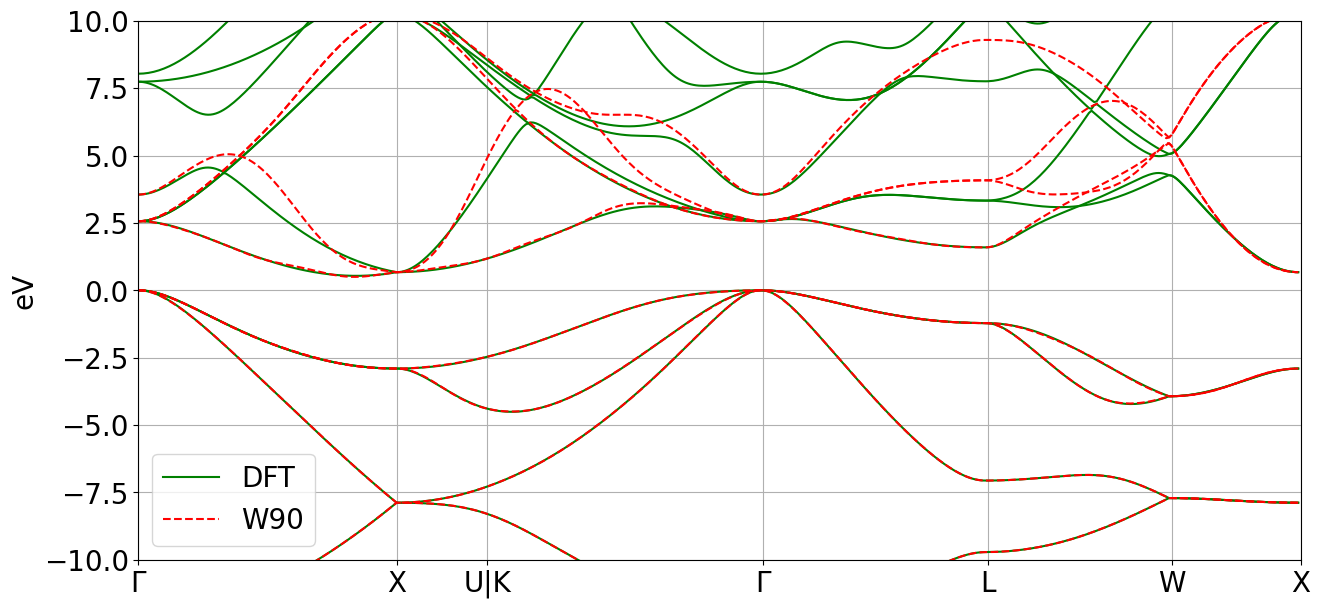

In [19]:
fig,ax=plt.subplots(figsize=[15,7])
plt.plot(bandsqe-max(bands_qe.get_bands()[:,b-1]),'-',color='green')
plt.plot(w90_qe-max(w90_qe[:,b-1]),'--',color='red')

plt.plot(bandsqe[0,b-1]-max(bands_qe.get_bands()[:,b-1]),'-',color='green',label = 'DFT')
plt.plot(w90_qe[0,b-1]-max(w90_qe[:,b-1]),'--',color='red',label = 'W90')
plt.ylim(-10,10)

plt.grid()
plt.xticks(l_x,l_names)
plt.tick_params(axis='both',labelsize=20)
plt.xlim(0,max(l_x))
plt.ylabel("eV",fontsize=20)

#plt.ylim(-2,5)
plt.legend(fontsize=20)

#plt.savefig('plot_.pdf')